In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter, RandomSurvivalForest
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.inspection import permutation_importance
from lifelines.utils import concordance_index

In [11]:
# Read the excel file
df = pd.read_excel('../Data/RADCURE_Clinical_v04_20241219.xlsx', sheet_name='RADCURE_TCIA_Clinical_r2_offset')
df.head()

,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,...,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge,ContrastEnhanced
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
2,RADCURE-0007,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
3,RADCURE-0009,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,S (suspicious),2008-05-27,0,0
4,RADCURE-0010,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0


In [13]:
# Data Exploration
df.columns

Index(['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status',
       'Ds Site', 'Subsite', 'T', 'N', 'M ', 'Stage', 'Path', 'HPV',
       'Tx Modality', 'Chemo', 'RT Start', 'Dose', 'Fx', 'Last FU', 'Status',
       'Length FU', 'Date of Death', 'Cause of Death', 'Local', 'Date Local',
       'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca',
       'Date 2nd Ca', 'RADCURE-challenge', 'ContrastEnhanced'],
      dtype='object')

In [14]:
print(df['Status'].unique())

['Dead' 'Alive']


In [15]:
print(df['Stage'].unique())

['IVB' 'I' 'IVA' 'III' 'II' nan 'IV' 0 'IIIC' 'IB' 'X' 'IIA' 'IIIA' 'IVC'
 'IIB']


###  Kaplan-Meier Analysis

In [17]:
# Define early and advanced stages
early_stages = ['I', 'IA', 'IB', 'II', 'IIA', 'IIB']
advanced_stages = ['III', 'IIIA', 'IIIB', 'IIIC', 'IV', 'IVA', 'IVB', 'IVC']

def classify_stage(stage):
    if pd.isna(stage):
        return 'Unknown'
    stage = str(stage).strip().upper()
    if stage in early_stages:
        return 'Early'
    elif stage in advanced_stages:
        return 'Advanced'
    else:
        return 'Unknown'

df['Stage Group'] = df['Stage'].apply(classify_stage)
print(df['Stage Group'].value_counts())

Stage Group
Advanced    2513
Early        756
Unknown       77
Name: count, dtype: int64


In [16]:
print (df['Tx Modality'].unique())

['RT alone' 'ChemoRT' 'RT + EGFRI' 'ChemoRT ' 'Postop RT alone']


In [ ]:
def simplify_tx(tx):
    if tx == 'ChemoRT':
        return 'ChemoRT'
    elif tx in ['RT alone', 'Postop RT alone']:
        return 'RT alone'
    elif 'EGFRI' in tx:
        return 'RT + EGFRI'
    else:
        return 'Other'

df['Tx Group'] = df['Tx Modality'].apply(simplify_tx)
print(df['Tx Group'].value_counts())


Tx Group
RT alone      1861
ChemoRT       1413
RT + EGFRI      72
Name: count, dtype: int64


In [24]:
# Map status to 0 (Alive) and 1 (Dead)
status_map = {
    'Alive': 0,
    'Dead': 1
}

df['Event'] = df['Status'].map(status_map)

# Optionally drop rows with missing survival info
df = df.dropna(subset=['Length FU', 'Event'])


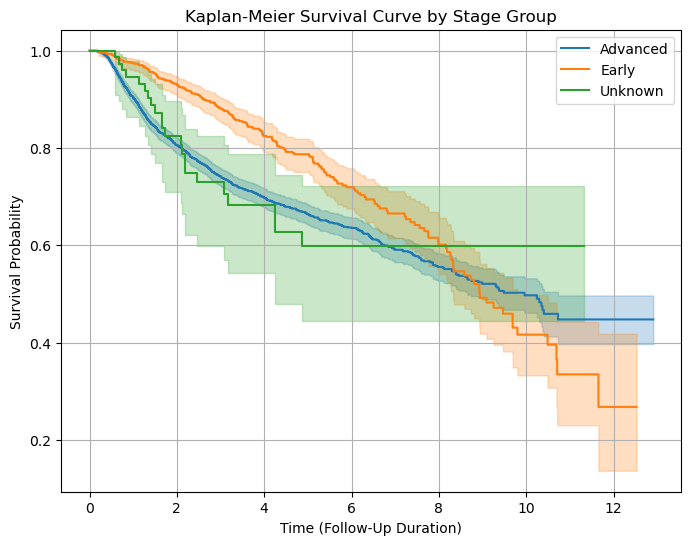

Log-rank test p-value (Stage Group: Early vs Advanced): 5.421236523259855e-06


In [ ]:
# Plot KM by Stage Group
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for label in df['Stage Group'].dropna().unique():
    group = df[df['Stage Group'] == label]
    kmf.fit(group['Length FU'], group['Event'], label=label)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Stage Group')
plt.xlabel('Time (Follow-Up Duration)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()

# Log-rank test (pairwise)
early = df[df['Stage Group'] == 'Early']
advanced = df[df['Stage Group'] == 'Advanced']

results = logrank_test(
    early['Length FU'], advanced['Length FU'],
    event_observed_A=early['Event'], event_observed_B=advanced['Event']
)
print("Log-rank test p-value (Stage Group: Early vs Advanced):", results.p_value)


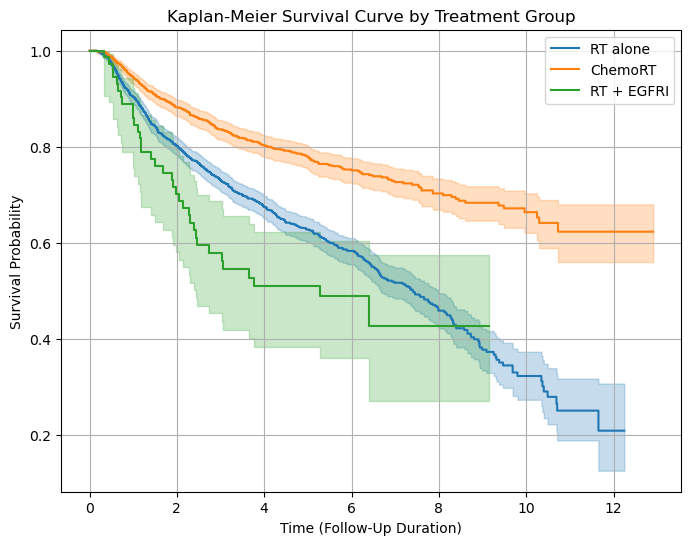

Log-rank test p-value (Tx Group: ChemoRT vs RT alone): 3.4102120832372066e-27


In [28]:
# Plot KM by Treatment Group
plt.figure(figsize=(8, 6))

for label in df['Tx Group'].dropna().unique():
    group = df[df['Tx Group'] == label]
    kmf.fit(group['Length FU'], group['Event'], label=label)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Treatment Group')
plt.xlabel('Time (Follow-Up Duration)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()

# Example log-rank test: ChemoRT vs RT alone
chemo = df[df['Tx Group'] == 'ChemoRT']
rt_alone = df[df['Tx Group'] == 'RT alone']

results_tx = logrank_test(
    chemo['Length FU'], rt_alone['Length FU'],
    event_observed_A=chemo['Event'], event_observed_B=rt_alone['Event']
)
print("Log-rank test p-value (Tx Group: ChemoRT vs RT alone):", results_tx.p_value)


### Cox propotional Hazard Regression

In [29]:
# Drop rows with missing data in relevant columns
cox_df = df[['Length FU', 'Event', 'Age', 'Sex', 'Stage Group', 'Tx Group']].dropna()

# Encode categorical variables
cox_df = pd.get_dummies(cox_df, columns=['Sex', 'Stage Group', 'Tx Group'], drop_first=True)

In [ ]:
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='Length FU', event_col='Event')

# Summary of coefficients and hazard ratios
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'Length FU'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7786.57
         time fit was run = 2025-07-14 00:08:29 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Age                  0.04      1.04      0.00            0.03            0.04                1.03                1.04
Sex_Male             0.06      1.06      0.08           -0.09            0.21                0.91                1.23
Stage Group_Early   -0.80      0.45      0.08           -0.97           -0.64                0.38                0.53
Stage Group_Unknown -0.40      0.67      0.22           -0.82            0.03                0.44                1.03
Tx Group_RT + EGFRI  0.56      1.75      0.18            0.20            0.92                1.22                2.51
Tx Group_RT alone    0.62      1.86      0.08            0.47            0.78                1.60                2.17

                     cmp to     z      p  -log2(p)
covariate                                         
Age                    0.00 11.59 <0.005    100.80
Sex_Male               0.00  0.73   0.46      1.11
Stage Group_Early      0.00 -9.51 <0.005     68.80
Stage Group_Unknown    0.00 -1.83   0.07      3.89
Tx Group_RT + EGFRI    0.00  3.06 <0.005      8.80
Tx Group_RT alone      0.00  7.91 <0.005     48.41
---
Concordance = 0.66
Partial AIC = 15585.14
log-likelihood ratio test = 369.24 on 6 df
-log2(p) of ll-ratio test = 252.28

In [ ]:
# Validate the Cox Proportional Hazards assumptions
# This will print warnings if assumptions are violated and generate diagnostic plots
cph.check_assumptions(cox_df, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
Age                 km             12.85 <0.005     11.54
                    rank           12.12 <0.005     10.97
Sex_Male            km              3.15   0.08      3.72
                    rank            3.23   0.07      3.79
Stage Group_Early   km             49.55 <0.005     38.91
                    rank           47.20 <0.005     37.18
Stage Group_Unknown km              0.00   0.98      0.03
                    rank            0.28   0.60      0.75
Tx Group_RT + EGFRI km              0.44   0.51      0.98
                    rank            0.64   0.42      1.24
Tx Group_RT alone   km              0.12   0.73      0.46
                    rank            0.04   0.84      0.25



1. Variable 'Age' failed the non-proportional test: p-value is 0.0003.

   Advice 1: the functional form of the variable 'Age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age' using pd.cut, and then specify it in `strata=['Age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Stage Group_Early' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Stage Group_Early', ...]`
in the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifel

[]

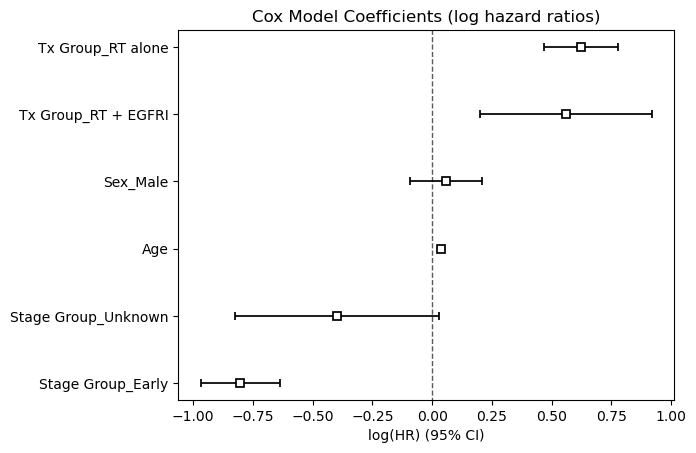

In [32]:
# Model Summary Plot
cph.plot()
plt.title("Cox Model Coefficients (log hazard ratios)")
plt.show()

### Random Survival Forests (RSF)

In [ ]:
# Prepare the data
rsf_df = df[['Length FU', 'Event', 'Age', 'Sex', 'Stage Group', 'Tx Group']].dropna()

# Encode categorical variables
rsf_df = pd.get_dummies(rsf_df, columns=['Sex', 'Stage Group', 'Tx Group'], drop_first=True)

# Create structured array for survival times and events
surv_data = Surv.from_dataframe('Event', 'Length FU', rsf_df)

# Drop target columns for features
X = rsf_df.drop(columns=['Length FU', 'Event'])


In [34]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, surv_data, test_size=0.2, random_state=42)

In [35]:
# Fit the Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=42)
rsf.fit(X_train, y_train)


RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=42)

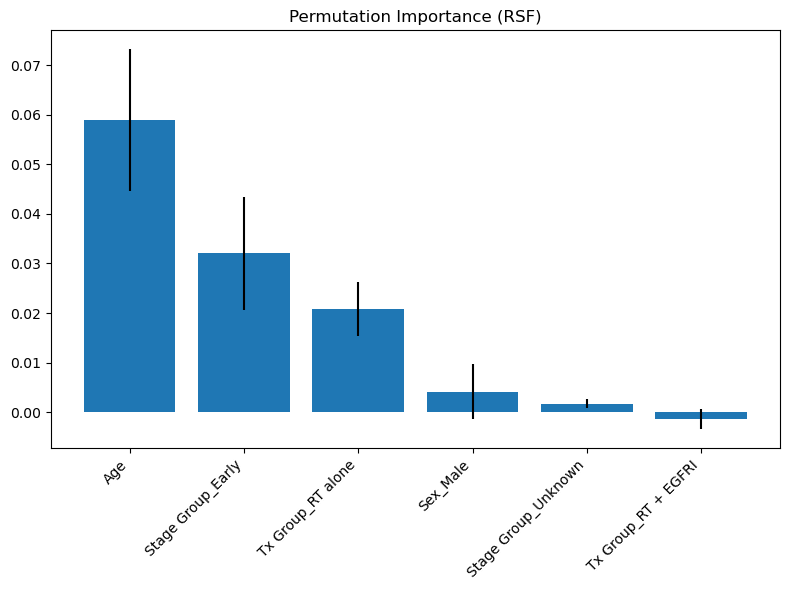

In [ ]:
# Since direct .feature_importances_ is not available:
# I have used Permutation Importance which measures change in model performance (C-index) when each variable is shuffled.

# Compute permutation importance on test set
result = permutation_importance(
    rsf, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(8, 6))
plt.bar(range(len(X.columns)), result.importances_mean[sorted_idx], yerr=result.importances_std[sorted_idx])
plt.xticks(range(len(X.columns)), X.columns[sorted_idx], rotation=45, ha='right')
plt.title("Permutation Importance (RSF)")
plt.tight_layout()
plt.show()


In [38]:
# C-Index Evaluation
rsf_c_index = rsf.score(X_test, y_test)
print(f"Random Survival Forest C-index: {rsf_c_index:.4f}")


Random Survival Forest C-index: 0.6084


In [ ]:
# Cox c-index for comparison

cox_test_df = rsf_df.iloc[X_test.index]
cox_test_pred = cph.predict_partial_hazard(cox_test_df)

cox_c_index = concordance_index(cox_test_df['Length FU'], -cox_test_pred, cox_test_df['Event'])
print(f"Cox Regression C-index: {cox_c_index:.4f}")


Cox Regression C-index: 0.6251
